In [728]:
import tensorflow as tf
import os 
import time
import glob
import matplotlib.pyplot as plt
import PIL
from IPython import display
import tensorflow.keras as keras
import tensorflow.keras.layers as layers
import numpy as np
from tensorflow.keras import backend as K
from PIL import Image
import pickle


In [729]:
# dataset load
filepath = 'E:/jo/船橋市高瀬下水処理場画像処理AI_20211113/5-1系/img/20211111132604.pickle'
f = open(filepath,'rb')
[x_train_resize,x_test_resize] = pickle.load(f)
f.close
# x_train_resize = x_train_resize[:10000]

<function BufferedReader.close>

In [730]:
TRAIN_BUF = 5000
BATCH_SIZE = 100
TEST_BUF = 200

In [731]:
train_images = x_train_resize.reshape(x_train_resize.shape[0], 128, 128, 1).astype('float32')
test_images = x_test_resize.reshape(x_test_resize.shape[0], 128, 128, 1).astype('float32')

# ランダム
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(TRAIN_BUF).batch(BATCH_SIZE)
test_dataset = tf.data.Dataset.from_tensor_slices(test_images).shuffle(TEST_BUF).batch(BATCH_SIZE)


In [732]:
class CVAE(tf.keras.Model):
  def __init__(self, latent_dim):
    super(CVAE, self).__init__()
    self.latent_dim = latent_dim
    self.inference_net = tf.keras.Sequential(
      [
          tf.keras.layers.InputLayer(input_shape=(128, 128, 1)),
          #1
          layers.Conv2D(filters=32, kernel_size=4, activation='relu', strides=(2,2),padding="same"),
          # layers.BatchNormalization(),
          #2
          layers.Conv2D(filters=32, kernel_size=4, activation='relu', strides=(2,2),padding="same"),
          # layers.BatchNormalization(),
          #3
          layers.Conv2D(filters=32, kernel_size=3, activation='relu', strides=(1,1),padding="same"),
          # layers.BatchNormalization(),
          #4
          layers.Conv2D(filters=64, kernel_size=4, activation='relu', strides=(2,2),padding="same"),
          # layers.BatchNormalization(),
          #5
          layers.Conv2D(filters=64, kernel_size=3, activation='relu', strides=(1,1),padding="same"),
          # layers.BatchNormalization(),
          #6
          layers.Conv2D(filters=128, kernel_size=4, activation='relu', strides=(2,2),padding="same"),
          # layers.BatchNormalization(),
          #7
          layers.Conv2D(filters=64, kernel_size=3, activation='relu', strides=(1,1),padding="same"),
          # layers.BatchNormalization(),
          #8
          layers.Conv2D(filters=32, kernel_size=3, activation='relu', strides=(1,1),padding="same"),
          # layers.BatchNormalization(),
          #9
          layers.Conv2D(filters=100, kernel_size=8, activation='relu', strides=(1,1)),
          layers.BatchNormalization(),
          tf.keras.layers.Flatten(),
          # No activation
          tf.keras.layers.Dense(latent_dim + latent_dim),
      ]
    )

    self.generative_net = tf.keras.Sequential(
        [
          tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
          tf.keras.layers.Dense(units=1*1*100, activation=tf.nn.relu),
          tf.keras.layers.Reshape(target_shape=(1, 1, 100)),
          #9
          layers.Conv2DTranspose(filters=100, kernel_size=8, strides=1, activation='relu', output_padding=None,padding="same"),
          # layers.BatchNormalization(),
          #8
          layers.Conv2DTranspose(filters=32, kernel_size=3, strides=(1,1), activation='relu', output_padding=None,padding="same"),
          # layers.BatchNormalization(),
          #7
          layers.Conv2DTranspose(filters=64, kernel_size=3, strides=(1,1), activation='relu', output_padding=None,padding="same"),
          # layers.BatchNormalization(),
          #6
          layers.Conv2DTranspose(filters=128, kernel_size=4, strides=(2,2), activation='relu', output_padding=None,padding="same"),
          # layers.BatchNormalization(),
          #5
          layers.Conv2DTranspose(filters=64, kernel_size=3, strides=(1,1), activation='relu', output_padding=None,padding="same"),
          # layers.BatchNormalization(),
          #4
          layers.Conv2DTranspose(filters=64, kernel_size=4, strides=(2,2), activation='relu', output_padding=None,padding="same"),
          # layers.BatchNormalization(),
          #3
          layers.Conv2DTranspose(filters=32, kernel_size=3, strides=(1,1), activation='relu', output_padding=None,padding="same"),
          # layers.BatchNormalization(),
          # #2
          layers.Conv2DTranspose(filters=32, kernel_size=4, strides=(2,2), activation='relu', output_padding=None,padding="same"),
          layers.Conv2DTranspose(filters=32, kernel_size=4, strides=(2,2), activation='relu', output_padding=None,padding="same"),
          layers.Conv2DTranspose(filters=32, kernel_size=4, strides=(2,2), activation='relu', output_padding=None,padding="same"),
          layers.Conv2DTranspose(filters=32, kernel_size=4, strides=(2,2), activation='relu', output_padding=None,padding="same"),
          # layers.BatchNormalization(),
          # No activation
          layers.Conv2DTranspose(filters=1, kernel_size=4, strides=(2,2), activation='sigmoid',output_padding=None,padding="same"), 
        ]
    )

  @tf.function
  def sample(self, eps=None):
    if eps is None:
      eps = tf.random.normal(shape=(100, self.latent_dim))
    return self.decode(eps, apply_sigmoid=True)

  def encode(self, x):
    mean, logvar = tf.split(self.inference_net(x), num_or_size_splits=2, axis=1)
    return mean, logvar

  def reparameterize(self, mean, logvar):
    eps = tf.random.normal(shape=mean.shape)
    return eps * tf.exp(logvar * .5) + mean

  def decode(self, z, apply_sigmoid=False):
    logits = self.generative_net(z)
    if apply_sigmoid:
      probs = tf.sigmoid(logits)
      return probs

    return logits

In [739]:
optimizer = tf.keras.optimizers.Adam(1e-6)

def log_normal_pdf(sample, mean, logvar, raxis=1):
  log2pi = tf.math.log(2. * np.pi)
  return tf.reduce_sum(
      -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),
      axis=raxis)

@tf.function
def compute_loss(model, x):
  mean, logvar = model.encode(x)
  z = model.reparameterize(mean, logvar)
  x_logit = model.decode(z)

  squares = 0.5*(x_logit-x)**2
  logpx_z = -tf.reduce_sum(squares,[1,2,3])

  # squares = keras.losses.mean_squared_error(x,x_logit)
  # logpx_z = tf.reduce_sum(squares,[1,2])
  # logpz = log_normal_pdf(z, 0., 0.)
  # logqz_x = log_normal_pdf(z, mean, logvar)
  # return tf.reduce_mean(logpx_z +logpz -  logqz_x)

  logpz = log_normal_pdf(z, 0., 0.)
  logqz_x = log_normal_pdf(z, mean, logvar)
  return -tf.reduce_mean(logpx_z + logpz - logqz_x)

@tf.function
def compute_apply_gradients(model, x, optimizer):
  with tf.GradientTape() as tape:
    loss = compute_loss(model, x)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))

In [734]:
epochs = 100
latent_dim = 50
num_examples_to_generate = 9

# 保持随机向量恒定以进行生成（预测），以便更易于看到改进。
random_vector_for_generation = tf.random.normal(
    shape=[num_examples_to_generate, latent_dim])
model = CVAE(latent_dim)

In [735]:
model.inference_net.summary()
model.generative_net.summary()

Model: "sequential_148"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_599 (Conv2D)          (None, 64, 64, 32)        544       
_________________________________________________________________
conv2d_600 (Conv2D)          (None, 32, 32, 32)        16416     
_________________________________________________________________
conv2d_601 (Conv2D)          (None, 32, 32, 32)        9248      
_________________________________________________________________
conv2d_602 (Conv2D)          (None, 16, 16, 64)        32832     
_________________________________________________________________
conv2d_603 (Conv2D)          (None, 16, 16, 64)        36928     
_________________________________________________________________
conv2d_604 (Conv2D)          (None, 8, 8, 128)         131200    
_________________________________________________________________
conv2d_605 (Conv2D)          (None, 8, 8, 64)       

In [736]:
def generate_and_save_images(model, epoch, test_input):
  predictions = model.sample(test_input)
  fig = plt.figure(figsize=(10,10))

  for i in range(predictions.shape[0]):
      plt.subplot(3, 3, i+1)
      plt.imshow(predictions[i, :, :, 0], cmap='gray')
      plt.axis('off')

  # tight_layout 最小化两个子图之间的重叠
  plt.savefig('./graf/image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()
  return predictions

Epoch: 100, Test set ELBO: -26.651620864868164, time elapse for current epoch 2.0431876182556152


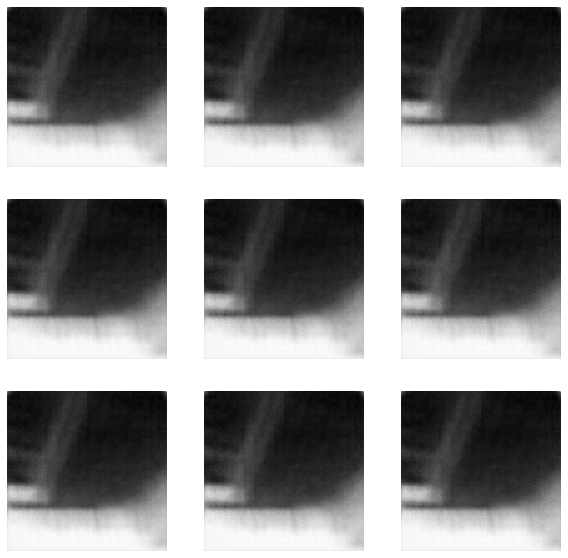

In [740]:
generate_and_save_images(model, 0, random_vector_for_generation)

for epoch in range(1, epochs + 1):
  start_time = time.time()
  for train_x in train_dataset:
    compute_apply_gradients(model, train_x, optimizer)
  end_time = time.time()

  if epoch % 1 == 0:
    loss = tf.keras.metrics.Mean()
    for test_x in test_dataset:
      loss(compute_loss(model, test_x))
    elbo = -loss.result()
    display.clear_output(wait=False)
    print('Epoch: {}, Test set ELBO: {}, '
          'time elapse for current epoch {}'.format(epoch,
                                                    elbo,
                                                    end_time - start_time))
    generate_and_save_images(
        model, epoch, random_vector_for_generation)

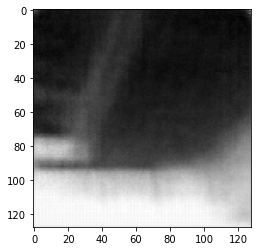

In [741]:
test_np = np.stack(list(test_dataset))
a =test_np[1][2]
xx = tf.reshape(a,[1,128,128,1])
mean, logvar = model.encode(xx)
num =tf.exp(logvar * .5) + mean
x_logit = model.decode(num,apply_sigmoid=True)
plt.imshow(x_logit[0, :, :, 0], cmap='gray')

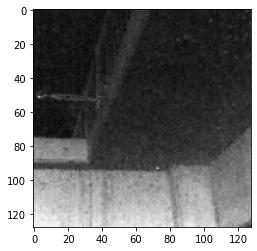

In [742]:
plt.imshow(a[:,:,0],cmap='gray')

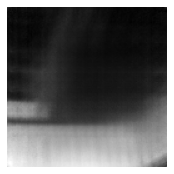

<tf.Tensor: shape=(1, 128, 128, 1), dtype=float32, numpy=
array([[[[0.557148  ],
         [0.54694074],
         [0.54692996],
         ...,
         [0.5375039 ],
         [0.54960734],
         [0.55387956]],

        [[0.54780084],
         [0.5412159 ],
         [0.53957695],
         ...,
         [0.539256  ],
         [0.54196167],
         [0.54106694]],

        [[0.54499656],
         [0.5414593 ],
         [0.538556  ],
         ...,
         [0.5380096 ],
         [0.5373723 ],
         [0.533788  ]],

        ...,

        [[0.65741265],
         [0.66153836],
         [0.6636244 ],
         ...,
         [0.5731965 ],
         [0.5787006 ],
         [0.5736609 ]],

        [[0.65675336],
         [0.65708566],
         [0.6607911 ],
         ...,
         [0.5749228 ],
         [0.5721637 ],
         [0.5629482 ]],

        [[0.6466874 ],
         [0.65357184],
         [0.65874815],
         ...,
         [0.5681802 ],
         [0.56323117],
         [0.57179594]]]], dty

In [351]:
random_vector_for_generation = tf.random.normal(shape=[1, 1000])
# print(random_vector_for_generation)
generate_and_save_images(model, 101, random_vector_for_generation)

In [284]:
# compute_loss(model,xx)
mean, logvar = model.encode(xx)
z = model.reparameterize(mean, logvar)
x_logit = model.decode(z)
# cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=xx)
squares = 0.5*(x_logit-xx)**2
logpx_z = tf.reduce_sum(squares,[1,2,3])

# logpx_z = -tf.reduce_sum(cross_ent, axis=[1, 2, 3])
logpz = log_normal_pdf(z, 0., 0.) #正規分布
logqz_x = log_normal_pdf(z, mean, logvar)

In [567]:
squares = keras.losses.mean_squared_error(xx,x_logit)
logpx_z = tf.reduce_sum(squares)
logpx_z

<tf.Tensor: shape=(), dtype=float32, numpy=1781.2346>

In [568]:
squares = 0.5*(x_logit-xx)**2
logpx_z = tf.reduce_sum(squares)
logpx_z

<tf.Tensor: shape=(), dtype=float32, numpy=890.6173>

In [658]:
path = "model/VAE1_5-1/"
model.save_weights(path)



In [659]:
model2 = CVAE(latent_dim)
model2.load_weights(path)

In [752]:
import AnomalyDetector as ad
thresh_area_ratio = 0.3
thresh_scum_num = 20
image_x =(a[:, :,0]*255).astype(np.uint8)
image_logit =(a[:, :,0]*255).astype(np.uint8)
source_image = Image.fromarray(image_x)
decode_image = Image.fromarray(image_logit) 
difference_image = ad.image_difference(source_image,decode_image,image_mode='GRAY')

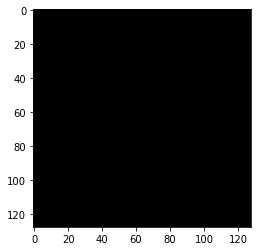

In [754]:
plt.imshow(difference_image,cmap='gray')
binary_image = ad.image_binarization(difference_image)
morph_image = ad.image_morphology(binary_image)
rect_datas = ad.image_rectangle(morph_image)
rect, scum_area, scum_num = ad.rect_datas_and_image(source_image, rect_datas, x_ratio=1, y_ratio=1)

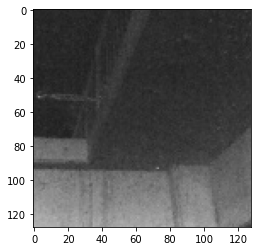

In [755]:
plt.imshow(rect,cmap='gray')

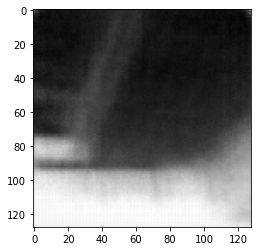

In [773]:
test_image = Image.open('E:/jo/funabashi_dataset/accuracy_img/5-1(128)/20210918021306.jpg')
array_test = np.asarray(test_image,dtype=np.float32)
array_test = array_test/255.
array_test = tf.reshape(array_test,[1,128,128,1])
mean, logvar = model.encode(array_test)
num =tf.exp(logvar * .5) + mean
x_logit = model.decode(num,apply_sigmoid=True)
plt.imshow(x_logit[0, :, :, 0], cmap='gray')



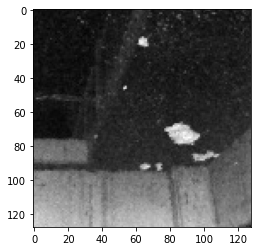

In [790]:
plt.imshow(test_image, cmap='gray')

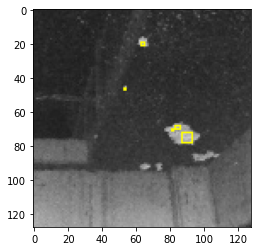

In [786]:
import AnomalyDetector as ad
thresh_area_ratio = 0.3
thresh_scum_num = 20
array_test = tf.reshape(array_test,[128,128,1])
x_logit = tf.reshape(x_logit,[128,128,1])
image_x =(array_test[:, :,0]*255)
image_x= np.asarray(image_x,dtype=np.uint8)
image_logit =(x_logit[:, :,0]*255)
image_logit =  np.asarray(image_logit,dtype=np.uint8)
source_image = Image.fromarray(image_x)
decode_image = Image.fromarray(image_logit) 
difference_image = ad.image_difference(source_image,decode_image,image_mode='GRAY')
binary_image = ad.image_binarization(difference_image)
morph_image = ad.image_morphology(binary_image)
rect_datas = ad.image_rectangle(morph_image)
rect, scum_area, scum_num = ad.rect_datas_and_image(source_image, rect_datas, x_ratio=1, y_ratio=1)
plt.imshow(rect,cmap='gray')

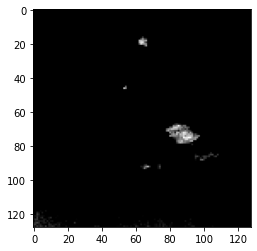

In [787]:
plt.imshow(difference_image,cmap='gray')

In [ ]:
import os
import numpy as np
import cv2
from time import time
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.manifold import TSNE
import pickle



In [ ]:

def plot_embedding_2D(data, label, title):
    x_min, x_max = np.min(data, 0), np.max(data, 0)
    data = (data - x_min) / (x_max - x_min)
    fig = plt.figure()
    for i in range(data.shape[0]):
        plt.text(data[i, 0], data[i, 1], str(label[i]),
                 color=plt.cm.Set1(label[i]),
                 fontdict={'weight': 'bold', 'size': 9})
    plt.xticks([])
    plt.yticks([])
    plt.title(title)
    return fig

In [821]:
import os
import numpy as np
import cv2
from time import time
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.manifold import TSNE
from tensorflow.keras.datasets import mnist
import tensorflow as tf


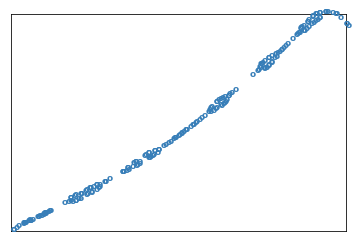

In [843]:
test_np = np.stack(list(test_dataset))
test_np =tf.reshape(test_np,[-1,128,128,1])
mean, logvar = model.encode(test_np)
num =tf.exp(logvar * .5) + mean
x_logit = model.decode(num,apply_sigmoid=True)
x = tf.reshape(x_logit,[-1,16384])
a1 = x
tsne = TSNE(n_components=2,init='pca')
x = np.asarray(x)
X_tsne = tsne.fit_transform(x)
x_min, x_max = X_tsne.min(0), X_tsne.max(0)
X_norm1 = (X_tsne - x_min) / (x_max - x_min)
for i in range(X_norm1.shape[0]):
    plt.text(X_norm1[i, 0], X_norm1[i, 1], str('o'), color=plt.cm.Set1(1), 
             fontdict={'weight': 'bold', 'size': 9})
plt.xticks([])
plt.yticks([])
plt.show()



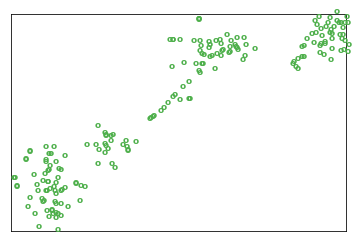

In [847]:
test_np = np.stack(list(test_dataset))
test_np =tf.reshape(test_np,[-1,128,128,1])
x = tf.reshape(test_np,[-1,16384])
a2 = x
tsne = TSNE(n_components=2,init='pca')
x = np.asarray(x)
X_tsne = tsne.fit_transform(x)
x_min, x_max = X_tsne.min(0), X_tsne.max(0)
X_norm2 = (X_tsne - x_min) / (x_max - x_min)
for i in range(X_norm2.shape[0]):
    plt.text(X_norm2[i, 0], X_norm2[i, 1], str('o'), color=plt.cm.Set1(2), 
             fontdict={'weight': 'bold', 'size': 9})
plt.xticks([])
plt.yticks([])
plt.show()



In [851]:
a3 =np.vstack((a1,a2))

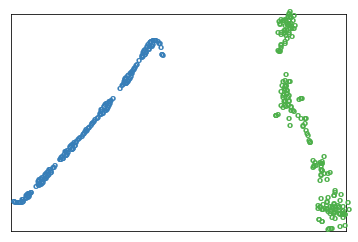

In [852]:

X_tsne = tsne.fit_transform(a3)
x_min, x_max = X_tsne.min(0), X_tsne.max(0)
X_norm = (X_tsne - x_min) / (x_max - x_min)
j = 0
for i in range(X_norm.shape[0]):
    if j >= 200:
        plt.text(X_norm[i, 0], X_norm[i, 1], str('o'), color=plt.cm.Set1(
            2), fontdict={'weight': 'bold', 'size': 9})
        j +=1
    else:
        plt.text(X_norm[i, 0], X_norm[i, 1], str('o'), color=plt.cm.Set1(
            1), fontdict={'weight': 'bold', 'size': 9})
        j +=1

plt.xticks([])
plt.yticks([])
plt.show()


In [825]:
autoencoder = tf.saved_model.load('C:/user/jo/gitLab/船橋市高瀬下水処理場画像処理AI/船橋市高瀬下水処理場画像処理AI_20211111/5-1系/model/20211111133119')

In [869]:
test_np = np.stack(list(test_dataset))
test_np= tf.reshape(test_np,[-1,128,128,1])
encoded_imgs = autoencoder.encoder(test_np).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

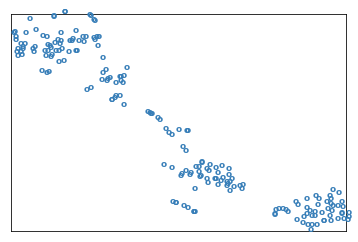

In [866]:
x = tf.reshape(decoded_imgs,[-1,16384])
a1 = x
tsne = TSNE(n_components=2,init='pca')
x = np.asarray(x)
X_tsne = tsne.fit_transform(x)
x_min, x_max = X_tsne.min(0), X_tsne.max(0)
X_norm1 = (X_tsne - x_min) / (x_max - x_min)
for i in range(X_norm1.shape[0]):
    plt.text(X_norm1[i, 0], X_norm1[i, 1], str('o'), color=plt.cm.Set1(1), 
             fontdict={'weight': 'bold', 'size': 9})
plt.xticks([])
plt.yticks([])
plt.show()


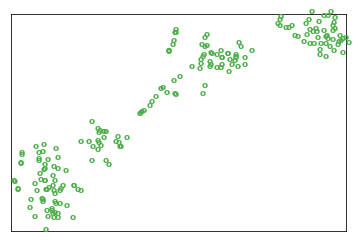

In [863]:
test_np =tf.reshape(test_np,[-1,128,128,1])
x = tf.reshape(test_np,[-1,16384])
a2 = x
tsne = TSNE(n_components=2,init='pca')
x = np.asarray(x)
X_tsne = tsne.fit_transform(x)
x_min, x_max = X_tsne.min(0), X_tsne.max(0)
X_norm2 = (X_tsne - x_min) / (x_max - x_min)
for i in range(X_norm2.shape[0]):
    plt.text(X_norm2[i, 0], X_norm2[i, 1], str('o'), color=plt.cm.Set1(2), 
             fontdict={'weight': 'bold', 'size': 9})
plt.xticks([])
plt.yticks([])
plt.show()

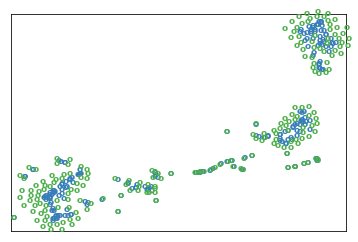

In [865]:
a3 =np.vstack((a1,a2))
X_tsne = tsne.fit_transform(a3)
x_min, x_max = X_tsne.min(0), X_tsne.max(0)
X_norm = (X_tsne - x_min) / (x_max - x_min)
j = 0
for i in range(X_norm.shape[0]):
    if j >= 200:
        plt.text(X_norm[i, 0], X_norm[i, 1], str('o'), color=plt.cm.Set1(
            2), fontdict={'weight': 'bold', 'size': 9})
        j +=1
    else:
        plt.text(X_norm[i, 0], X_norm[i, 1], str('o'), color=plt.cm.Set1(
            1), fontdict={'weight': 'bold', 'size': 9})
        j +=1

plt.xticks([])
plt.yticks([])
plt.show()


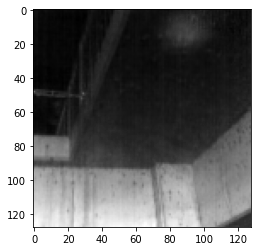

In [873]:
plt.imshow(decoded_imgs[0],cmap='gray')

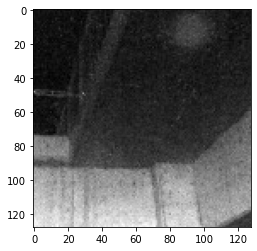

In [872]:
plt.imshow(test_np[0],cmap='gray')